# Credit Scoring with “Give Me Some Credit”  
**Author:** Akli Melissa  
**Date:** May 2025  

## Contents  
1. [Introduction](#intro)  
2. [Data Loading and preprocessing](#cleaning)  
3. [Training and evaluation](#split)    
4. [ROC & Confusion Matrix](#visuals)  


<a id="intro"></a>
## 1. Introduction  
In this notebook we build a credit-scoring model using the “Give Me Some Credit” dataset.

<a id="#cleaning"></a>
## 2. Data Loading and preprocessing  

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [100]:
# reading the data 
df = pd.read_csv('../data/GiveMeSomeCredit-training.csv', index_col=0)

# renaming the target 
df = df.rename(columns={'SeriousDlqin2yrs': 'Target'})

# checking if the data is correctly readed 
df.head()


,Target,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [101]:
# checking for any missing values
df.isnull().sum()

Target                                      0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [102]:
#handling the missing values 
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(df['NumberOfDependents'].mode()[0])

# checking again
print(df.isnull().sum())

Target                                  0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


In [103]:
# the dataset informations
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Target                                150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         150000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    150000 non-null  float64
dtypes: fl

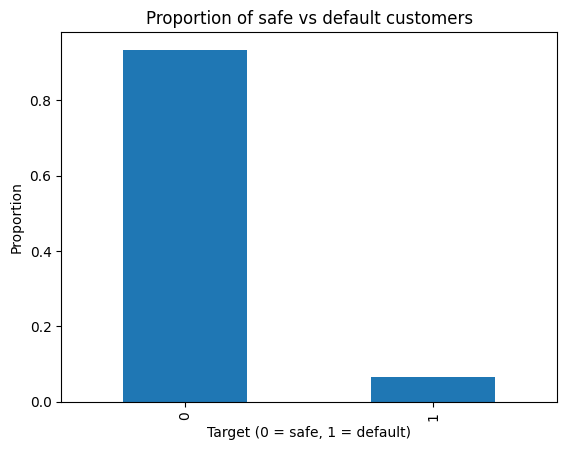

In [104]:
# visulazing the target y 
df['Target'].value_counts(normalize=True).plot.bar()
plt.title('Proportion of safe vs default customers')
plt.xlabel('Target (0 = safe, 1 = default)')
plt.ylabel('Proportion')
plt.show()


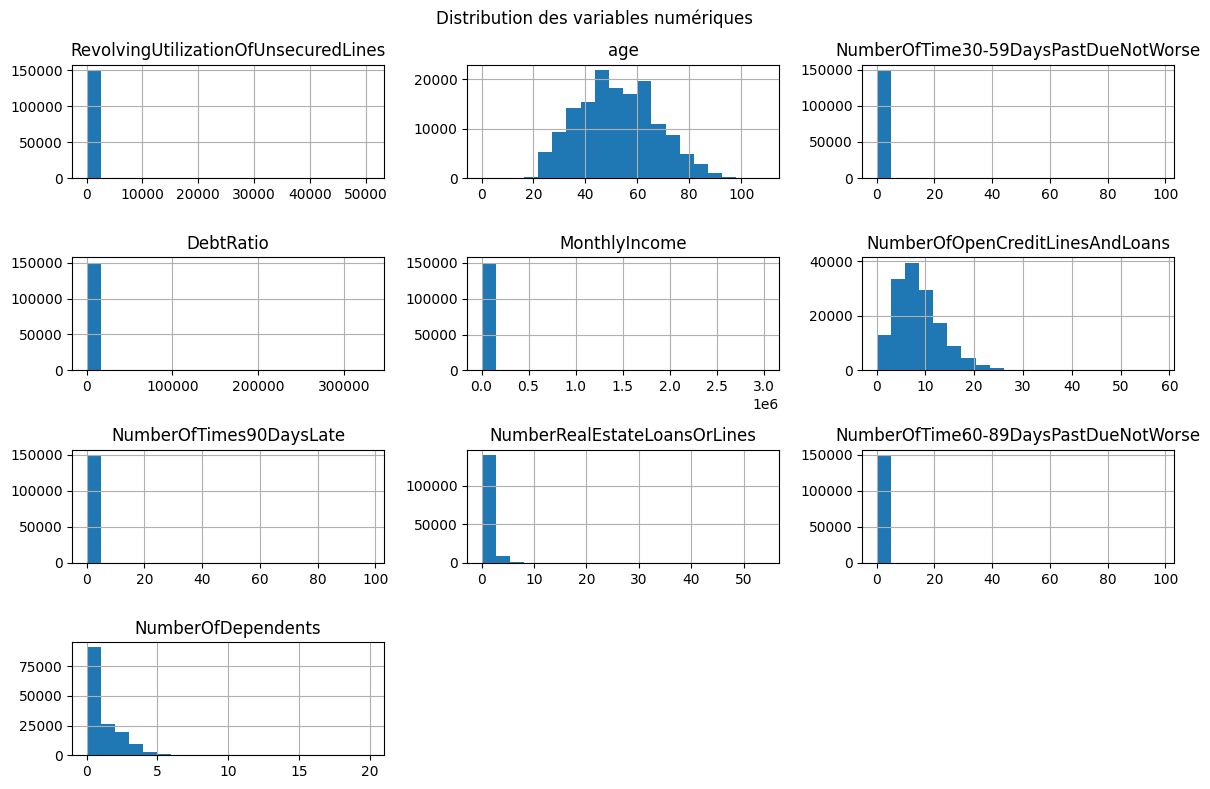

In [105]:
#  visulazing the inputs  
num_cols = df.select_dtypes(include='number').columns.drop('Target')
df[num_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribution des variables numériques')
plt.tight_layout()
plt.show()


 <a id="#split"></a>
## 3. Model Training and Evaluation 

In [106]:

from data_preprocessing import load_data, preprocess
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

X, y, feature_names = preprocess(df)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=12, stratify=y
)

#defining the pipelines 
pipelines = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, solver="liblinear")),
    ]),
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=12)),
    ]),
    "XGBoost": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", xgb.XGBClassifier(eval_metric="logloss", random_state=12)),
    ]),
}

results = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results[name] = {"Accuracy": acc, "AUC": auc}

res_df = pd.DataFrame(results).T
res_df

,Accuracy,AUC
Logistic Regression,0.934000,0.687007
Random Forest,0.935356,0.842433
XGBoost,0.934778,0.856675


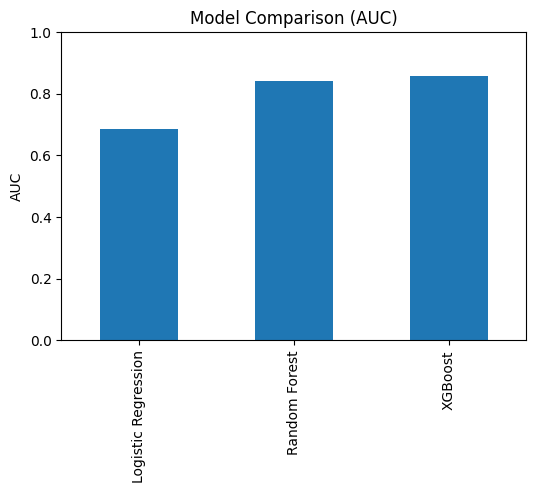

In [107]:
# results and models comparison 
import matplotlib.pyplot as plt
res_df["AUC"].plot(kind="bar", figsize=(6, 4), ylabel="AUC", title="Model Comparison (AUC)")
plt.ylim(0, 1)
plt.show()

 <a id="#visuals"></a>
## 4. Choosen model : ROC and Confusion Matrix

Best model: XGBoost


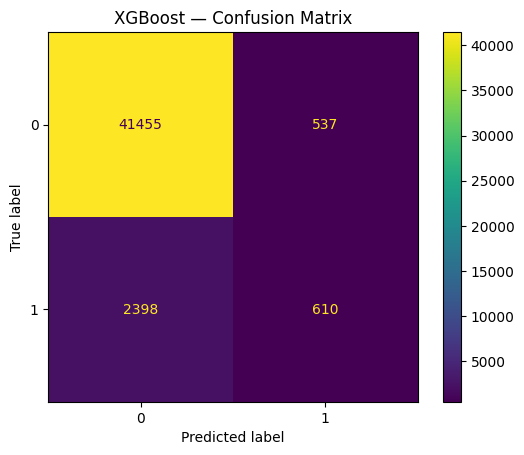

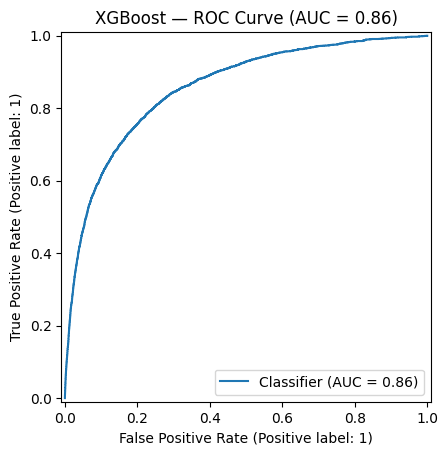

In [108]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# finding the best one
best_name = res_df["AUC"].idxmax()
best_pipe = pipelines[best_name]
print(f"Best model: {best_name}")

# testing it
y_pred = best_pipe.predict(X_test)
y_prob = best_pipe.predict_proba(X_test)[:, 1]

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred
)
plt.title(f"{best_name} — Confusion Matrix")
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(
    y_test, y_prob
)
plt.title(f"{best_name} — ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.show()
